In [1]:
# PROCESS THE YOUNG STARS CATAOLOG:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/620/A172
#
#
# ZACK REEVES
# CREATED: 2023
#
# VERSIONS:
#  1.1  OCT 2023 CREATE JUPYTER NOTEBOOK

In [2]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas'
metadata['sub_project'] = 'Young Stars'

metadata['catalog'] = '3D mapping of young stars in the solar neighbourhood with Gaia DR2 (Zari+, 2023)'
metadata['author'] = 'Zari+'
metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Young Stars'
metadata['data_group_desc'] = 'Young Star catalog'
metadata['fileroot'] = 'ys'

In [6]:
import pandas as pd
import numpy as np
import sys
import collections

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import Angle
from astropy.table import unique, vstack, Table

from astroquery.vizier import Vizier

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [4]:
#Reading in the catalog with Vizier
#We specify the row limit to make sure we get all the stars in the catalog
#We place constraints on the Parallax as a preliminary thresh
#We specify columns = ['**'] to get all of the columns, not just the default ones
catalog = Vizier(catalog='J/A+A/620/A172', columns=['**'], row_limit=-1).query_constraints(Plx='> 0.0')

In [8]:
#This catalog comes with 4 tables:
# - Pre main sequence (has SIMBAD column)
# - Upper main sequence (has SIMBAD column)
# - Pre main sequence S=2 tangential velocity
# - Pre main sequence S=3 tangential velocity

#We first label each object with the table it came from
catalog[0]['table'] = catalog[0].Column(data=['Pre-main sequence']*len(catalog[0]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')

catalog[1]['table'] = catalog[1].Column(data=['Upper main sequence']*len(catalog[1]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')

catalog[2]['table'] = catalog[2].Column(data=['Pre-main sequence S=2']*len(catalog[2]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')

catalog[3]['table'] = catalog[3].Column(data=['Pre-main sequence S=3']*len(catalog[3]),
                                        meta = collections.OrderedDict([('ucd', 'meta.table')]),
                                        description='Catalog Table')


#We concatenate these tables into one for a full catalog
#Some stars exist in multiple tables and present as duplicate objects
#We remove duplicate objects using the unique function
data = unique(vstack([catalog[0], catalog[1], catalog[2], catalog[3]], 
              metadata_conflicts='silent'), keys='Source', keep='first')

In [12]:
data

recno,Source,GLON,GLAT,Plx,e_Plx,pmGLON,e_pmGLON,pmGLAT,e_pmGLAT,pmlbcorr,RV,e_RV,Gmag,BPmag,RPmag,E_BR_RP_,chi2AL,NgAL,AG,E_BP-RP_,UWE,Simbad,_RA.icrs,_DE.icrs,table,parallax_over_error
,,deg,deg,mas,mag,mas / yr,mas / yr,mas / yr,mas / yr,,km / s,km / s,mag,mag,mag,,,,mag,mag,,,deg,deg,,
int32,int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float64,float32,float64,float64,float64,float64,float64,int16,float32,float32,float32,str6,float64,float64,str21,float64
78256,915553884118144,175.08323524451,-47.08903941868,2.1634,0.0734,-0.639,0.116,-6.936,0.116,0.0000,--,--,9.07101,9.12869,8.99339,1.15283,487.73,115,0.6006,0.3019,--,Simbad,45.40817337014,2.16826997394,Upper main sequence,29.474115145091943
79083,1195551392247936,173.61179863296,-48.25887009822,6.1016,0.1752,12.503,0.192,-4.343,0.194,0.0000,--,--,6.57496,6.58252,6.62812,1.13375,764.03,120,0.3309,0.1706,--,Simbad,43.88155084926,2.01821675745,Upper main sequence,34.82648393769648
77712,1402912413121792,173.24716308805,-47.28239584380,2.0920,0.1177,15.205,0.145,-5.333,0.146,0.0000,--,--,10.36702,10.42734,10.21292,1.18454,657.79,103,0.2829,0.1369,--,Simbad,44.37518745590,2.89590163789,Upper main sequence,17.7740012329856
77714,1546703623466880,171.67621197870,-48.22301132547,2.8533,0.0463,0.033,0.084,2.348,0.084,0.0000,--,--,10.03341,10.22926,9.74427,1.16817,352.2,119,0.6511,0.3200,--,Simbad,42.95930603592,2.92045698074,Upper main sequence,61.62634797209846
6592,1939920764151808,173.72413813809,-45.85198831324,8.9190,0.0799,7.783,0.149,-4.880,0.148,0.1680,--,--,14.35860,15.91036,13.13935,1.48514,785.87,129,0.2365,0.1311,2.5175,Simbad,45.59978350959,3.70765186755,Pre-main sequence,111.6270386553669
76614,2015099871749760,173.17076762967,-46.47763857888,3.3820,0.0579,5.135,0.095,-2.605,0.095,0.0000,--,--,8.68511,8.82983,8.48334,1.15470,417.61,128,0.4080,0.2112,--,Simbad,44.88972814394,3.51754443653,Upper main sequence,58.41105317378968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,6916469618124518272,45.46442635259,-28.70471306285,2.0457,0.0625,-7.410,0.074,-2.792,0.096,-0.1700,31.612,1.153,10.55336,10.77069,10.21229,1.18341,1899.8,402,0.4538,0.2222,--,Simbad,313.84874072928,-2.84411356309,Upper main sequence,32.7312


In [10]:
#fixing parallax units (Vizier labels it as a magnitude, probably meant milliarcseconds (mag versus mas))
data['Plx'].unit=u.mas

In [11]:
#thresh on parallax error (cutting on >10% error removes 1614 stars)
data['parallax_over_error'] = [data['Plx'][i] / data['e_Plx'][i] for i in range(len(data))]
data.remove_rows(np.where(data['parallax_over_error']<10)[0])

In [14]:
#calculating distance in light years and parsecs
calculations.get_distance(data, parallax='Plx', use='parallax')

In [15]:
#calculating cartesian coordinates
calculations.get_cartesian(data, glon='GLON', glat='GLAT', pmglon='pmGLON', pmglat='pmGLAT', 
                           radial_velocity='RV', frame='galactic')

<function matplotlib.pyplot.show(close=None, block=None)>

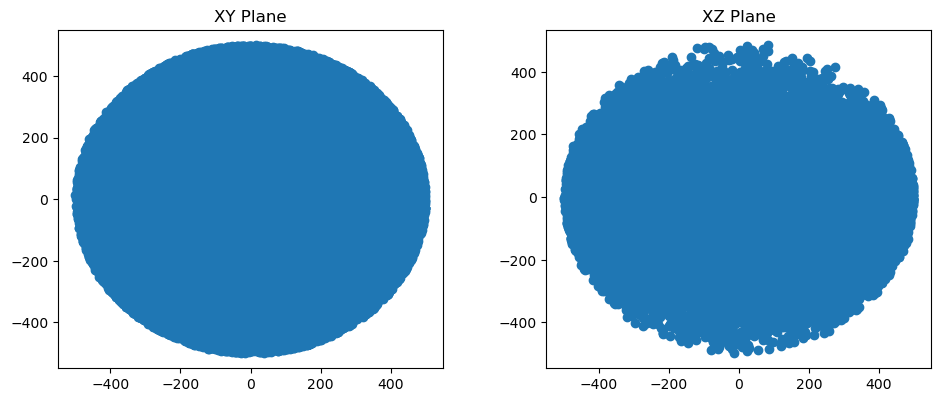

In [16]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

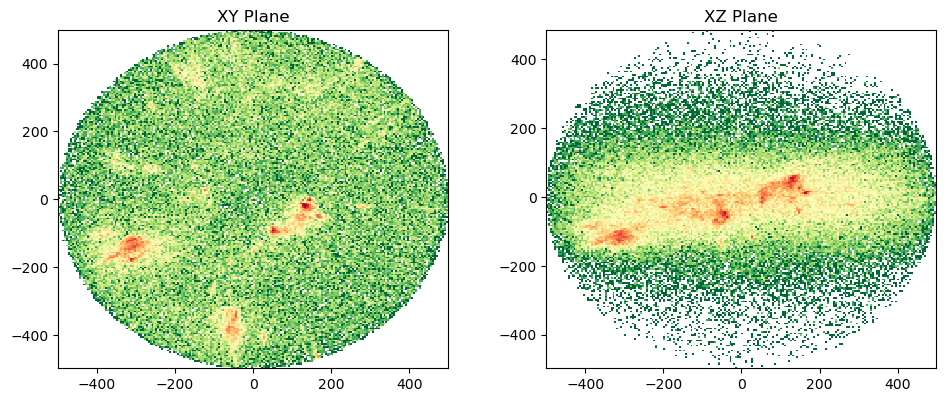

In [17]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [31]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['Source']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                 description='Gaia DR2 Source ID')

#construct a label column
data['label'] = ['GaiaDR2_'+ str(source) for source in data['Source']]  #leaving for now in case we want to add other labels

In [32]:
#construct a metadata table
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'dist_ly', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,Position (x coordinate) in parsecs
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
4,u,km / s,float64,,6,,vel.cartesian.u,Heliocentric velocity towards Galactic Center
5,v,km / s,float64,,6,,vel.cartesian.v,Heliocentric velocity towards Galactic Rotation
6,w,km / s,float64,,6,,vel.cartesian.w,Heliocentric velocity towards Galactic North Pole
7,speed,,float64,5,2,,vel.speed,Total heliocentric velocity
8,speck_label,,str,,,*,meta.id,Gaia DR2 Source ID


In [ ]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [ ]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))